# Nuth and Kääb (2011) co-registration method 

We know from running the workflow of [FEniCS_ice](https://github.com/EdiGlacUQ/fenics_ice) with two different velocity data sets that there is a co-registration problem between ITSLive and MEaSUREs ice velocity files.

Here we apply a co-registration correction to the MEaSUREs data set using the ITSLive data as reference. We rely on the [xdem](https://xdem.readthedocs.io/en/latest/index.html) library which is the new extension of the [demcoreg package](https://github.com/dshean/demcoreg). All tools found in demcoreg are have been integrated in xdem.

The method that we are using is the [Nuth and Kääb (2011)](https://xdem.readthedocs.io/en/latest/auto_examples/plot_nuth_kaab.html#nuth-kaab-2011-coregistration) coregistration method, which allows for horizontal and vertical shifts to be estimated and corrected for. 

In library, this approach is implemented through the `xdem.coreg.NuthKaab` class. The method estimates translation and bias corrections iteratively by solving a cosine equation to model the direction at which the DEM (of vel tif) is most likely offset.

> In our case the DEM's to correct will be our Velocity components VX/VY `.tif` files!

First, the tif's are compared to get a dVEL, and slope/aspect maps are created from the reference tiff file (in our case ITSlive velocity files). Together, these three products contain the information about in which direction the offset is. A cosine function is solved using these products to find the most probable offset direction, and an appropriate horizontal shift is applied to fix it. This is an iterative process, and cosine functions with suggested shifts are applied in a loop, continuously refining the total offset. The loop is stopped either when the maximum iteration limit is reached, or when the spatial_stats_nmad between the two products stops improving significantly.

For more information about the approach, see [Nuth and Kääb (2011)](https://xdem.readthedocs.io/en/latest/coregistration.html#nuth-and-kaab-2011).

In [1]:
import numpy as np
import xdem
from configobj import ConfigObj
import os
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import geoutils as gu

In [2]:
import sys
sys.path.append('/home/brecinos/smith_glacier')

In [3]:
from ficetools import velocity as vel_tools

### 1. Making a mask of the ice regions 

Before correcting the Velocity data we need to give the program a mask containing the area of the domain that is cover by ice. This is needed as we need to define a stable ground, by masking out features that are assumed to be unstable e.g. ice shelf.

Reading the necessary data and cropping Bedmachine mask to the Smith Glacier domain

In [4]:
config = ConfigObj(os.path.expanduser('~/co_registration_velfiles/config.ini'))

In [5]:
dr = xr.open_dataset(config['bedmachine'], decode_times=False)

mask_bm = dr.mask

smith_bbox = {'xmin': -1609000.0,
              'xmax': -1381000.0,
              'ymin': -718450.0,
              'ymax': -527000.0}

mask_smith = vel_tools.crop_velocity_data_to_extend(mask_bm, smith_bbox, return_xarray=True)

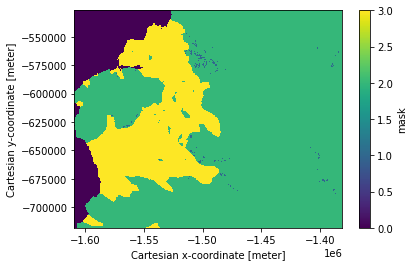

In [6]:
mask_smith.plot()

Process the mask with XDEM so it has the same resolution as the ITSLive data set. This involves converting the mask into a shapefile and later into a numpy array with the same shape as the ITSLive data set

In [7]:
# Get all coordinates where there is ice
y, x = np.where(mask_smith.data > 0)
lat = mask_smith.x.isel(x=x)
lon = mask_smith.y.isel(y=y)

# Make the list of coodinates a Polygon
polygon_geom = Polygon(zip(lat, lon))

# Make sure we keep BM projection! 
crs=dr.proj4
crs

'+init=epsg:3031'

In [8]:
from pyproj import CRS
crs=CRS("EPSG:3031")
crs

<Derived Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We use Geopandas to greate the polygon

<AxesSubplot:>

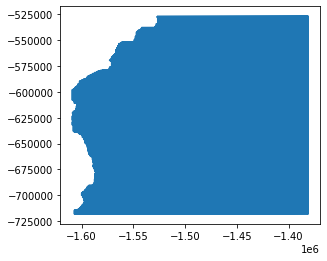

In [9]:
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom.boundary])  
polygon.plot()

Now lets start applying the [Nuth and Kääb (2011)](https://xdem.readthedocs.io/en/latest/auto_examples/plot_nuth_kaab.html#nuth-kaab-2011-coregistration)

### 2. Correcting VX and VXSTD component 

In [10]:
import geoutils as gu
ice_sheet_outlines = gu.Vector(polygon)

Reading the data as tif! 

In [11]:
reference_vx = xdem.DEM('vx_smith_itslive.tif')
vx_tobe_alinged = xdem.DEM('vx_smith_measures.tif')
vxstd_tobe_alinged = xdem.DEM('stdvx_smith_measures.tif')

In [12]:
reference_vx.crs

CRS.from_epsg(3031)

We need MEaSUREs in the same crs! 

In [13]:
vx_tobe_alinged.crs = reference_vx.crs
vxstd_tobe_alinged.crs = reference_vx.crs

We plot the differences before we aling the data 

In [14]:
diff_before_vx = reference_vx - vx_tobe_alinged

Lets correct the VX and STD components:

1. First we correct for vertical shifts via the Blockwise method

In [15]:
blockwise = xdem.coreg.BlockwiseCoreg(xdem.coreg.NuthKaab(), subdivision=64)

blockwise.fit(reference_vx, vx_tobe_alinged)
block_aligned_vx = blockwise.apply(vx_tobe_alinged)


# Same trandform to STDVX 
block_aligned_vxstd = blockwise.apply(vxstd_tobe_alinged)

diff_afterblockwise_vx = reference_vx - block_aligned_vx


In [16]:
print(f"Error before: {xdem.spatialstats.nmad(diff_before_vx):.2f} m/yr")
print(f"Error after: {xdem.spatialstats.nmad(diff_afterblockwise_vx):.2f} m/yr")

Error before: 23.81 m/yr
Error after: 18.10 m/yr


In [17]:
inlier_mask = ~ice_sheet_outlines.create_mask(reference_vx)
inlier_mask = np.invert(inlier_mask)

# Call the coregistration method
nuth_kaab = xdem.coreg.NuthKaab()

# Get the fit 
nuth_kaab.fit(reference_vx, block_aligned_vx, inlier_mask=inlier_mask)

# Apply the transform 
aligned_vx = nuth_kaab.apply(block_aligned_vx)

# Same trandform to STDVX 
aligned_vxstd = nuth_kaab.apply(vxstd_tobe_alinged)

Lets check the difference after 

In [18]:
diff_after_vx = reference_vx - aligned_vx

In [19]:
print(f"Error before: {xdem.spatialstats.nmad(diff_before_vx):.2f} m/yr")
print(f"Error after: {xdem.spatialstats.nmad(diff_after_vx):.2f} m/yr")

Error before: 23.81 m/yr
Error after: 18.04 m/yr


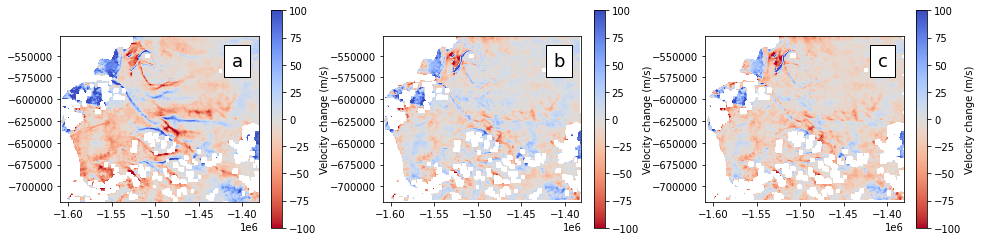

In [20]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec

fig1 = plt.figure(figsize=(16, 4))#, constrained_layout=True)
spec = gridspec.GridSpec(1, 3, wspace=0.3, hspace=0.25)

ax0 = plt.subplot(spec[0])
diff_before_vx.show(cmap="coolwarm_r", vmin=-100, vmax=100, cb_title="Velocity change (m/s)", ax=ax0)
at = AnchoredText('a', prop=dict(size=18), frameon=True, loc='upper right')
ax0.add_artist(at)

ax1 = plt.subplot(spec[1])
diff_afterblockwise_vx.show(cmap="coolwarm_r", vmin=-100, vmax=100, cb_title="Velocity change (m/s)", ax=ax1)
at = AnchoredText('b', prop=dict(size=18), frameon=True, loc='upper right')
ax1.add_artist(at)

ax2 = plt.subplot(spec[2])
diff_after_vx.show(cmap="coolwarm_r", vmin=-100, vmax=100, cb_title="Velocity change (m/s)", ax=ax2)
at = AnchoredText('c', prop=dict(size=18), frameon=True, loc='upper right')
ax2.add_artist(at)

plt.show()

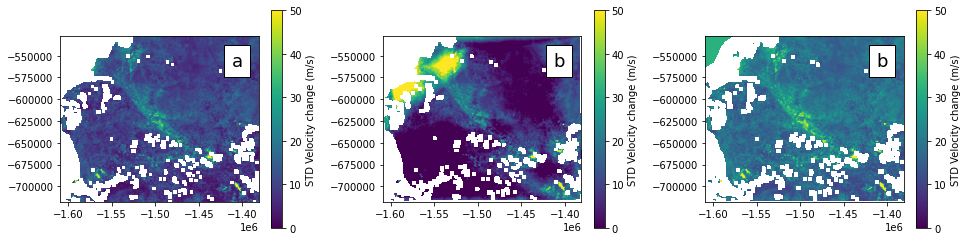

In [21]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec

fig1 = plt.figure(figsize=(16, 4))#, constrained_layout=True)
spec = gridspec.GridSpec(1, 3, wspace=0.3, hspace=0.25)

ax0 = plt.subplot(spec[0])
vxstd_tobe_alinged.show(cmap="viridis", vmin=0, vmax=50, cb_title="STD Velocity change (m/s)", ax=ax0)
at = AnchoredText('a', prop=dict(size=18), frameon=True, loc='upper right')
ax0.add_artist(at)

ax1 = plt.subplot(spec[1])
block_aligned_vxstd.show(cmap="viridis", vmin=0, vmax=50, cb_title="STD Velocity change (m/s)", ax=ax1)
at = AnchoredText('b', prop=dict(size=18), frameon=True, loc='upper right')
ax1.add_artist(at)


ax2 = plt.subplot(spec[2])
aligned_vxstd.show(cmap="viridis", vmin=0, vmax=50, cb_title="STD Velocity change (m/s)", ax=ax2)
at = AnchoredText('b', prop=dict(size=18), frameon=True, loc='upper right')
ax2.add_artist(at)

plt.show()

We will correct the ocean part later! For now lets save the new tifs 

In [22]:
# aligned_vx.save("blockwise_aligned_vel_vx.tif")
# aligned_vxstd.save("blockwise_aligned_vel_stdvx.tif")

### 3. Correcting VY and VYSTD component 

In [23]:
reference_vy = xdem.DEM('vy_smith_itslive.tif')
vy_tobe_alinged = xdem.DEM('vy_smith_measures.tif')
vystd_tobe_alinged = xdem.DEM('stdvy_smith_measures.tif')

In [24]:
reference_vy.crs

vy_tobe_alinged.crs = reference_vy.crs
vystd_tobe_alinged.crs = reference_vy.crs

diff_before_vy = reference_vy - vy_tobe_alinged

In [25]:
blockwise = xdem.coreg.BlockwiseCoreg(xdem.coreg.NuthKaab(), subdivision=64)

blockwise.fit(reference_vy, vy_tobe_alinged)
block_aligned_vy = blockwise.apply(vy_tobe_alinged)


# Same trandform to STDVX 
block_aligned_vystd = blockwise.apply(vystd_tobe_alinged)

diff_afterblockwise_vy = reference_vy - block_aligned_vy


In [26]:
print(f"Error before: {xdem.spatialstats.nmad(diff_before_vy):.2f} m/yr")
print(f"Error after: {xdem.spatialstats.nmad(diff_afterblockwise_vy):.2f} m/yr")

Error before: 24.32 m/yr
Error after: 20.31 m/yr


In [27]:
inlier_mask = ~ice_sheet_outlines.create_mask(reference_vy)
inlier_mask = np.invert(inlier_mask)

# Call the coregistration method
nuth_kaab = xdem.coreg.NuthKaab()

# Get the fit 
nuth_kaab.fit(reference_vy, block_aligned_vy, inlier_mask=inlier_mask)

# Apply the transform 
aligned_vy = nuth_kaab.apply(block_aligned_vy)

# Same trandform to STDVX 
aligned_vystd = nuth_kaab.apply(vystd_tobe_alinged)

In [28]:
diff_after_vy = reference_vy - aligned_vy

In [29]:
print(f"Error before: {xdem.spatialstats.nmad(diff_before_vy):.2f} m/yr")
print(f"Error after: {xdem.spatialstats.nmad(diff_after_vy):.2f} m/yr")

Error before: 24.32 m/yr
Error after: 20.08 m/yr


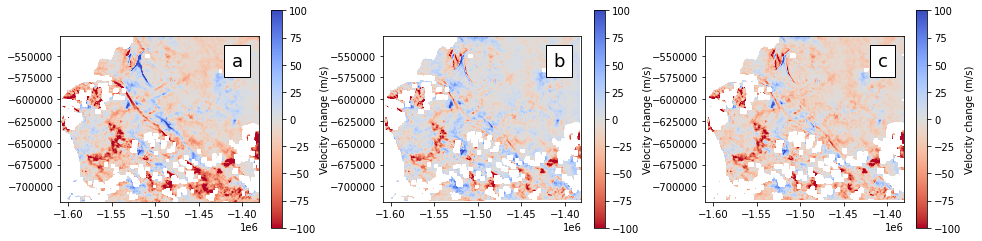

In [30]:
fig1 = plt.figure(figsize=(16, 4))#, constrained_layout=True)
spec = gridspec.GridSpec(1, 3, wspace=0.3, hspace=0.25)

ax0 = plt.subplot(spec[0])
diff_before_vy.show(cmap="coolwarm_r", vmin=-100, vmax=100, cb_title="Velocity change (m/s)", ax=ax0)
at = AnchoredText('a', prop=dict(size=18), frameon=True, loc='upper right')
ax0.add_artist(at)

ax1 = plt.subplot(spec[1])
diff_afterblockwise_vy.show(cmap="coolwarm_r", vmin=-100, vmax=100, cb_title="Velocity change (m/s)", ax=ax1)
at = AnchoredText('b', prop=dict(size=18), frameon=True, loc='upper right')
ax1.add_artist(at)

ax2 = plt.subplot(spec[2])
diff_after_vy.show(cmap="coolwarm_r", vmin=-100, vmax=100, cb_title="Velocity change (m/s)", ax=ax2)
at = AnchoredText('c', prop=dict(size=18), frameon=True, loc='upper right')
ax2.add_artist(at)

plt.show()

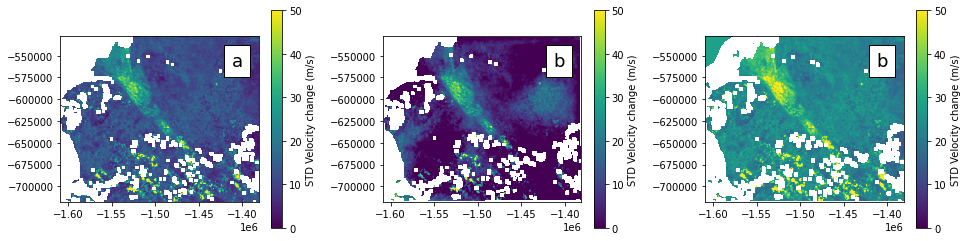

In [31]:
fig1 = plt.figure(figsize=(16, 4))#, constrained_layout=True)
spec = gridspec.GridSpec(1, 3, wspace=0.3, hspace=0.25)

ax0 = plt.subplot(spec[0])
vystd_tobe_alinged.show(cmap="viridis", vmin=0, vmax=50, cb_title="STD Velocity change (m/s)", ax=ax0)
at = AnchoredText('a', prop=dict(size=18), frameon=True, loc='upper right')
ax0.add_artist(at)

ax1 = plt.subplot(spec[1])
block_aligned_vystd.show(cmap="viridis", vmin=0, vmax=50, cb_title="STD Velocity change (m/s)", ax=ax1)
at = AnchoredText('b', prop=dict(size=18), frameon=True, loc='upper right')
ax1.add_artist(at)


ax2 = plt.subplot(spec[2])
aligned_vystd.show(cmap="viridis", vmin=0, vmax=50, cb_title="STD Velocity change (m/s)", ax=ax2)
at = AnchoredText('b', prop=dict(size=18), frameon=True, loc='upper right')
ax2.add_artist(at)

plt.show()

In [32]:
# aligned_vy.save("blockwise_aligned_vel_vy.tif")
# aligned_vystd.save("blockwise_aligned_vel_stdvy.tif")